# CanESM5 GMD paper Figure 11

### history
- NCS, setup basic example, 2019-05-1

In [5]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import iris
import iris.analysis.cartography
import iris.quickplot as qplt
import iris.plot as iplt
from cdo import *
import glob
import os
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3


cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [6]:
%store -r start 
%store -r end
%store -r color_dict

In [7]:
#cdo remapping to the ERA5 grid horizontal

regrid=False

if regrid:
    uas_file='uas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
    ifile = os.path.join('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Amon/uas/gn/v20190429/', uas_file)
    ofile = 'input_data/processed_data/remap_era5_' + uas_file
    cdo.remapbil('input_data/obs/NEIL/era5/era5-u_t_2000.nc', input=ifile, output=ofile, options='-L')       
    
    uas_file_CanESM2 = 'uas_Amon_CanESM2_historical_r1i1p1_185001-200512.nc'    
    ifile = os.path.join('input_data/CanESM2_small_ensemble/mon/atmos/uas/r1i1p1/', uas_file_CanESM2)
    ofile = 'input_data/processed_data/remap_era5_' + uas_file_CanESM2
    cdo.remapbil('input_data/obs/NEIL/era5/era5-u_t_2000.nc', input=ifile, output=ofile, options='-L')  
    
    infile = 'input_data/obs/NEIL/era5/era5-u_t_2000.nc'  
    outfile = 'input_data/obs/NEIL/era5/era5_gridarea.nc'
    cdo.gridarea(input=infile, output=outfile)  

In [8]:
#get uas data and calc means, zonal means, and anomalies

uas = xr.open_dataset('input_data/processed_data/remap_era5_uas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['uas'].squeeze().rename( {'longitude':'lon', 'latitude':'lat'}).sel(time=slice(start,end))
uas_mean = uas.mean(dim='time')
uas_zm   = uas.mean(dim=['lon', 'time'])

uas_canesm2 = xr.open_dataset('input_data/processed_data/remap_era5_uas_Amon_CanESM2_historical_r1i1p1_185001-200512.nc')['uas'].squeeze().rename( {'longitude':'lon', 'latitude':'lat'}).sel(time=slice(start,end))
uas_canesm2_mean = uas_canesm2.mean(dim='time')
uas_canesm2_zm   = uas_canesm2.mean(dim=['lon', 'time'])

uas_obs = xr.open_dataset('input_data/obs/NEIL/era5/era5_uas_monthlymean_1979-2019.nc')['u10'].rename( {'longitude':'lon', 'latitude':'lat'}).squeeze().sel(time=slice(start,end))
uas_obs_mean = uas_obs.mean(dim='time')
uas_obs_zm   = uas_obs.mean(dim=['lon', 'time'])

uas_anom = uas_mean - uas_obs_mean

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


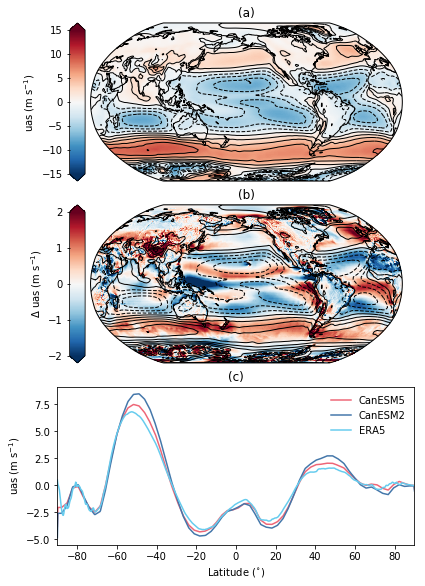

In [9]:
#plotting - CanESM5 mean and anomaly for uas; and zonal mean of CanESM5, CanESM2, and obs for uas
fig = plt.figure(figsize=(6.4, 9.6), constrained_layout=False)
outer_grid = fig.add_gridspec(3, 1, wspace=0.25, hspace=0.15)

axt = plt.subplot(outer_grid[0], projection=ccrs.Robinson(central_longitude=200))
axm = plt.subplot(outer_grid[1], projection=ccrs.Robinson(central_longitude=200))
axb = plt.subplot(outer_grid[2])
    
cmap2=plt.cm.RdBu_r
cb_uas = axt.pcolormesh(uas.lon, uas.lat, uas_mean, cmap=cmap2, vmin=-15, vmax=15, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, axt, cb_uas, extend='both', label=r'uas (m s$^{-1}$)')
cs=axt.contour(uas.lon, uas.lat, uas_mean, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
axt.set_title('(a)')

cb_uas_anom = axm.pcolormesh(uas.lon, uas.lat, uas_anom, cmap='RdBu_r', vmin=-2, vmax=2, transform=ccrs.PlateCarree(), rasterized=True)
pltm.add_cbar('left', fig, axm, cb_uas_anom, extend='both', label=r'$\Delta$ uas (m s$^{-1}$)')
css=axm.contour(uas.lon, uas.lat, uas_mean, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
axm.set_title('(b)')

for ax in [axt, axm]:
    #ax.add_feature(cfeature.LAND,zorder=100, edgecolor='k')
    ax.coastlines()
    
axb.plot(uas.lat, uas_zm, color=color_dict['CanESM5'], label='CanESM5')
axb.plot(uas_canesm2.lat, uas_canesm2_zm, color=color_dict['CanESM2'], label='CanESM2')
axb.plot(uas_obs.lat, uas_obs_zm, color=color_dict['ERA5'], label='ERA5')
axb.legend(frameon=False)   
axb.set_xlim([-90,90])
axb.set_xlabel('Latitude ($^{\circ}$)')
axb.set_ylabel('uas (m s$^{-1}$)')
axb.set_title('(c)')

fig.savefig('plots/fig-11_atmos_uas.png', bbox_inches='tight', dpi=300)
fig.savefig('plots/fig-11_atmos_uas.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for global time means
xyzt = 'TTFF'
av_dims = ['time'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections, )
weight = xr.open_dataset('input_data/obs/NEIL/era5/era5_gridarea.nc')['cell_area']
calc_skill_score=True


#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM2']
model_datasets    = [uas_mean,uas_canesm2_mean]
model_fulldatasets = [uas.sel(time=slice(start, end)), uas_canesm2.sel(time=slice(start, end))]

obs_names    = ['ERA5','ERA5']
obs_datasets    = [uas_obs_mean,uas_obs_mean]
obs_fulldatasets = [uas_obs.sel(time=slice(start, end)),uas_obs.sel(time=slice(start, end))]

stats_names = ['uas_global_timemean','uas_global_timemean_CanESM2'] #names for json file
varslist = ['uas','uas']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

In [ ]:
##### statistics - for 1D zonal means
xyzt = 'FTFF'
av_dims = ['time','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections, )
weight = None
calc_skill_score=True

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM2']  
model_datasets    = [uas_zm,uas_canesm2_zm]
model_fulldatasets = [uas.sel(time=slice(start, end)), uas_canesm2.sel(time=slice(start, end))]

obs_names    = ['ERA5','ERA5']
obs_datasets    = [uas_obs_zm,uas_obs_zm]
obs_fulldatasets = [uas_obs.sel(time=slice(start, end)),uas_obs.sel(time=slice(start, end))]

stats_names = ['uas_zonal_timemean','uas_zonal_timemean_CanESM2'] #names for json file
varslist = ['uas','uas']


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)